In [4]:
package PDBehavior {
    import ScalarValues::*;
  

    action def ManuallyDispenseFood{
        first start;
    
        then merge continueOpening;
        action def PutButton { out cmd : Integer; }

        then action monitor: PutButton;

        then decide;
          if monitor.cmd == 1 then open;
          if monitor.cmd == 0 then endOpen;

        action open : DispenserOpen{
            in cmd = monitor.cmd;
        }
        then continueOpening;

        action endOpen :EndOpen;

        then done;

        item def Food;
        action def EndOpen;
        action def DispenserOpen {
            in cmd: Integer;
        }
        
    }

}

Package PDBehavior (cdd98853-7637-4cab-bd50-5c9aca324df0)


In [9]:
package PetFoodDispenser {
    import ScalarValues::*;
    import SI::*;
    import PDBehavior::*;
            
    package SchedulePartDef {
        part def Screen;
        part def Button;
    }
    
    package HopperDef {
        port def FoodInPort {
            in item foodSupply: Food;
        }
    
        port def DispensePort {
            out item foodSupply: Food;
        }
    }
    
    perform action manuallyDispenseFood[*] : ManuallyDispenseFood;
    perform action recordVioce; // TBD long push recording/ click place
    perform action autmaticDispenseFood;  // TBD 
    perform action refill;  // TBD open lid, put food, state to filled, lock the lid
    
    part def FoodDispenser {
        part scheduler: Scheduler;
        part foodHopper: FoodHopper;
        part bowl: Bowl;
        part monitor: Monitor;
        part charginsystem: ChargingSystem;
        part voiceRecorder: VoiceRecorder;
    }
    
    part foodDispenser: FoodDispenser{
        // do redefines
    }
    
    part def Scheduler {
   
        attribute dispensedPortions: Integer;
        attribute meetsPerDay: Integer;
  
        part screen: SchedulePartDef::Screen ;
        part dispenseButton: SchedulePartDef::Button;
        part voiceRecordButton: SchedulePartDef::Button;
        part scheduleButton: SchedulePartDef::Button[2];
    }

    part def FoodHopper{
        attribute remainingFood : Integer;
        part tank: Tank;
        part lid: Lid;
        
        connect lid to tank; // Todo: other connection
        port foodInPort: HopperDef::FoodInPort;
        port fooddispensePort: HopperDef::DispensePort;
    
    }

    part def Bowl;
    item def DesiccantBag;
    item def Food{            
        attribute foodMass:>ISQ::mass;
    }
    
    part def Lid{
        part holder: DesiccantBagHolder;
        item dbag: DesiccantBag;
    }
    part def DesiccantBagHolder;
    
    part def Tank;
    abstract part def DCAdapter {
        part cable: Cable;
    }
    part def VoiceRecorder {
        attribute volume: Integer;
        attribute maxTime: Integer;
        part buttons: SchedulePartDef::Button[1..4];
    }
    part def Monitor; // To monitor how much food is dispensed
    
    part def ChargingSystem {
        // TODO
        part adapter:DispenserAdpater;
    }
    part def DispenserAdpater:> DCAdapter {
        part redefines cable {
            attribute redefineslength = 1.49[m];
        }
    }
    part def Cable{
        attribute length: Real;
    }
    
    analysis def DualPowerAnalysis{
        return isRemoteBetter : Boolean;
        objective LocalOrRemoteCtlAnalysisObjective {
            doc /* determine whether to provide a mobile contoller
             * for the pet food dispenser. 
             * The development of mobile app raises up the overall cost but have a better user experience
             * which may conflict with the cost requirement.
             */
        }
    }

    
}

Package PetFoodDispenser (574a6bfb-a2b9-4acd-ae3e-6c34282e4f9c)


In [11]:
package FDFriendlyVerfication {
    import ScalarValues::*;
	import SI::*;
	import VerificationCases::*;
	
	import PetFoodDispenser::*;
	
	requirement def FoodDispenserRequirement;
	
	requirement userFriendlySpecification{
    	subject foodDispenser; 
    	requirement <'1'> voiceRecordTimeRequirement: FoodDispenserRequirement {
    		doc /*The user shell be able to record voice of up to 10s */
    		attribute maxTimeRequired = 10;
    		attribute actualMaxTime = 10;
    		assume constraint {maxTimeRequired==actualMaxTime}
    	}
    	requirement <'2'> voicePlayVolumeRequirement: FoodDispenserRequirement {
    		doc /* The volume shell set up as default in range [50, 60] decibels */
    		attribute volumeMaxRequired = 60;
    		attribute volumeMinRequired = 50;
    		attribute actualVolume: Integer;
    		assume constraint {volumeMinRequired<=actualVolume<=volumeMaxRequired}
    	}
    	requirement <'3'> recoderReliableRequirement: FoodDispenserRequirement;
    	requirement <'4'> bowlMaterialRequirement: FoodDispenserRequirement;
    	requirement bowlTiltRequirement: FoodDispenserRequirement;
    	requirement lockerRequirement: FoodDispenserRequirement;
		requirement <'7'> temperatureRequirement: FoodDispenserRequirement {
			doc /* The device shall work well between [-20, 40] degree */
			attribute temperatureMinRequired = -20;
			attribute temperatureMaxRequired = 40;
			attribute actualTemp: Integer;
			assume constraint {temperatureMinRequired<=actualTemp<=temperatureMaxRequired}
		}
		requirement <'8'> kibbleSizeRequirement:FoodDispenserRequirement {
			doc /* The kibble shall between 2 - 10 mm */
			attribute kibbleMaxSize = 10;
			attribute kibbleMinSize = 2;
			attribute actualKibbleSize: Integer;
			assume constraint {kibbleMinSize<=actualKibbleSize<=kibbleMaxSize}
		}
		requirement <'9'> setupStepRequirement: FoodDispenserRequirement {
			attribute expectedSteps = 3;
			attribute acutalSteps: Integer;
		}
		requirement <'10'> powerStandardRequirement: FoodDispenserRequirement {
			doc /* 5v DC */
			attribute adapter = 5;
		}
		requirement <'11'> foodAccessibilityRequirement: FoodDispenserRequirement;
		requirement <'12'> movabilityRequirement: FoodDispenserRequirement;
    }
    
    
   
	// Test case for 10s voice record objective
    verification def VoiceRecordMaxTimeTest{
    	subject foodDispenser:FoodDispenser; 
    	objective {
			verify userFriendlySpecification.voiceRecordTimeRequirement;
		}
		return verdict: Boolean;
    }
    
    // Temperature test
    verification def TemperatureTest{
    	subject foodDispenser:FoodDispenser;
		objective {
			verify userFriendlySpecification.temperatureRequirement;
		}
		return verdict: Boolean;
    }

	verification def KibbleSizeTest{
		subject foodDispenser:FoodDispenser;
		objective {
			verify userFriendlySpecification.kibbleSizeRequirement;
		}
		return verdict: Boolean;
	}

	verification def SetupStepsTest{
		subject foodDispenser:FoodDispenser;
		objective {
			verify userFriendlySpecification.setupStepRequirement;
		}
		return verdict: Boolean;
	}
    
    verification def MovabilityTest{
    	subject foodDispenser:FoodDispenser;
    	objective {
    		verify userFriendlySpecification.movabilityRequirement;
    	}
		return verdict: Boolean;
    }

	verification def PowerStandardTest{
		subject foodDispenser:FoodDispenser;
		objective {
    		verify userFriendlySpecification.powerStandardRequirement;
    	}
		return verdict: Boolean;
	}

	verification def FoodAccessibilityTest{
		subject foodDispenser:FoodDispenser;
		objective {
			verify userFriendlySpecification.foodAccessibilityRequirement;
		}
		return verdict: Boolean;
	}
    
    verification def VoiceRecordVolumeTest{
    	subject foodDispenser:FoodDispenser; 
    	objective {
    		verify userFriendlySpecification.voicePlayVolumeRequirement;
    	}
    	return verdict: Boolean;
    }
    verification def VoiceRecordReliabilityTest{
    	subject foodDispenser:FoodDispenser; 
    	objective {
    		verify userFriendlySpecification.recoderReliableRequirement;
    	}
    	return verdict: Boolean;
    }
    
    // Test case pet health objective
    verification def BowlMaterialTest{
    	subject foodDispenser:FoodDispenser; 
    	objective {
    		verify userFriendlySpecification.bowlMaterialRequirement;
    	}
    	return verdict: Boolean;
    }
    verification def BowlTiltTest{
    	subject foodDispenser:FoodDispenser; 
    	objective {
    		verify userFriendlySpecification.bowlTiltRequirement;
    	}
    	return verdict: Boolean;
    }
    verification def LockerTest{
    	subject foodDispenser:FoodDispenser; 
    	objective {
    		verify userFriendlySpecification.lockerRequirement;
    	}
    	return verdict: Boolean;
    }
    
    verification voiceRecordMaxTimeTest: VoiceRecordMaxTimeTest; // It's play by dispenser part, recoder, do query and match.
    verification voiceRecordVolumeTest: VoiceRecordVolumeTest; // ditto
    verification voiceRecordReliabilityTest: VoiceRecordReliabilityTest; // Need a actor, turn off the  power and try if the replay of voice work or not.
    verification bowlMaterialTest: BowlMaterialTest; // only part: bowl involved,  do query and match 
    verification bowlTiltTest: BowlTiltTest; // only part bowl involved, do query and match 
    verification lockerTest: LockerTest;  // need a actor. Test with different pulling forces(1 pound/3 pound/6pound)
    verification temperatureTest: TemperatureTest; // Place the dispenser in different temperature environment 
    verification movabilityTest: MovabilityTest; // Have a middle-age-person tried to move the dispenser see if it's easily movable
    verification kibbleSizeTest: KibbleSizeTest; // Test with oversize and smallsize kibble to test the functionality
    verification setupStepsTest: SetupStepsTest; // Have a person (age 15 - 25) try to setup the dispenser to see if statisfy 3 steps
    verification powerStandardTest: PowerStandardTest; // Test with 5v DC power with basic functionality
    verification foodAccessibilityTest: FoodAccessibilityTest; // Having different size/kind pet to test the accessibility of the food
}



Package FDFriendlyVerfication (d5e6e728-9463-45fe-9afb-c7cb870afadf)


In [13]:
package FDFriendlyVerfication {
    import ScalarValues::*;
	import SI::*;
	import VerificationCases::*;
	
	import PetFoodDispenser::*;
	
	requirement def FoodDispenserRequirement;
	
	requirement userFriendlySpecification{
    	subject foodDispenser; 
    	requirement <'1'> voiceRecordTimeRequirement: FoodDispenserRequirement {
    		doc /*The user shell be able to record voice of up to 10s */
    		attribute maxTimeRequired = 10;
    		attribute actualMaxTime = 10;
    		assume constraint {maxTimeRequired==actualMaxTime}
    	}
    	requirement <'2'> voicePlayVolumeRequirement: FoodDispenserRequirement {
    		doc /* The volume shell set up as default in range [50, 60] decibels */
    		attribute volumeMaxRequired = 60;
    		attribute volumeMinRequired = 50;
    		attribute actualVolume: Integer;
    		assume constraint {volumeMinRequired<=actualVolume<=volumeMaxRequired}
    	}
    	requirement <'3'> recoderReliableRequirement: FoodDispenserRequirement;
    	requirement <'4'> bowlMaterialRequirement: FoodDispenserRequirement;
    	requirement bowlTiltRequirement: FoodDispenserRequirement;
    	requirement lockerRequirement: FoodDispenserRequirement;
		requirement <'7'> temperatureRequirement: FoodDispenserRequirement {
			doc /* The device shall work well between [-20, 40] degree */
			attribute temperatureMinRequired = -20;
			attribute temperatureMaxRequired = 40;
			attribute actualTemp: Integer;
			assume constraint {temperatureMinRequired<=actualTemp<=temperatureMaxRequired}
		}
		requirement <'8'> kibbleSizeRequirement:FoodDispenserRequirement {
			doc /* The kibble shall between 2 - 10 mm */
			attribute kibbleMaxSize = 10;
			attribute kibbleMinSize = 2;
			attribute actualKibbleSize: Integer;
			assume constraint {kibbleMinSize<=actualKibbleSize<=kibbleMaxSize}
		}
		requirement <'9'> setupStepRequirement: FoodDispenserRequirement {
			attribute expectedSteps = 3;
			attribute acutalSteps: Integer;
		}
		requirement <'10'> powerStandardRequirement: FoodDispenserRequirement {
			doc /* 5v DC */
			attribute adapter = 5;
		}
		requirement <'11'> foodAccessibilityRequirement: FoodDispenserRequirement;
		requirement <'12'> movabilityRequirement: FoodDispenserRequirement;
    }
    
    
   
	// Test case for 10s voice record objective
    verification def VoiceRecordMaxTimeTest{
    	subject foodDispenser:FoodDispenser; 
    	objective {
			verify userFriendlySpecification.voiceRecordTimeRequirement;
		}
		return verdict: Boolean;
    }
    
    // Temperature test
    verification def TemperatureTest{
    	subject foodDispenser:FoodDispenser;
		objective {
			verify userFriendlySpecification.temperatureRequirement;
		}
		return verdict: Boolean;
    }

	verification def KibbleSizeTest{
		subject foodDispenser:FoodDispenser;
		objective {
			verify userFriendlySpecification.kibbleSizeRequirement;
		}
		return verdict: Boolean;
	}

	verification def SetupStepsTest{
		subject foodDispenser:FoodDispenser;
		objective {
			verify userFriendlySpecification.setupStepRequirement;
		}
		return verdict: Boolean;
	}
    
    verification def MovabilityTest{
    	subject foodDispenser:FoodDispenser;
    	objective {
    		verify userFriendlySpecification.movabilityRequirement;
    	}
		return verdict: Boolean;
    }

	verification def PowerStandardTest{
		subject foodDispenser:FoodDispenser;
		objective {
    		verify userFriendlySpecification.powerStandardRequirement;
    	}
		return verdict: Boolean;
	}

	verification def FoodAccessibilityTest{
		subject foodDispenser:FoodDispenser;
		objective {
			verify userFriendlySpecification.foodAccessibilityRequirement;
		}
		return verdict: Boolean;
	}
    
    verification def VoiceRecordVolumeTest{
    	subject foodDispenser:FoodDispenser; 
    	objective {
    		verify userFriendlySpecification.voicePlayVolumeRequirement;
    	}
    	return verdict: Boolean;
    }
    verification def VoiceRecordReliabilityTest{
    	subject foodDispenser:FoodDispenser; 
    	objective {
    		verify userFriendlySpecification.recoderReliableRequirement;
    	}
    	return verdict: Boolean;
    }
    
    // Test case pet health objective
    verification def BowlMaterialTest{
    	subject foodDispenser:FoodDispenser; 
    	objective {
    		verify userFriendlySpecification.bowlMaterialRequirement;
    	}
    	return verdict: Boolean;
    }
    verification def BowlTiltTest{
    	subject foodDispenser:FoodDispenser; 
    	objective {
    		verify userFriendlySpecification.bowlTiltRequirement;
    	}
    	return verdict: Boolean;
    }
    verification def LockerTest{
    	subject foodDispenser:FoodDispenser; 
    	objective {
    		verify userFriendlySpecification.lockerRequirement;
    	}
    	return verdict: Boolean;
    }
    
    verification voiceRecordMaxTimeTest: VoiceRecordMaxTimeTest; // It's play by dispenser part, recoder, do query and match.
    verification voiceRecordVolumeTest: VoiceRecordVolumeTest; // ditto
    verification voiceRecordReliabilityTest: VoiceRecordReliabilityTest; // Need a actor, turn off the  power and try if the replay of voice work or not.
    verification bowlMaterialTest: BowlMaterialTest; // only part: bowl involved,  do query and match 
    verification bowlTiltTest: BowlTiltTest; // only part bowl involved, do query and match 
    verification lockerTest: LockerTest;  // need a actor. Test with different pulling forces(1 pound/3 pound/6pound)
    verification temperatureTest: TemperatureTest; // Place the dispenser in different temperature environment 
    verification movabilityTest: MovabilityTest; // Have a middle-age-person tried to move the dispenser see if it's easily movable
    verification kibbleSizeTest: KibbleSizeTest; // Test with oversize and smallsize kibble to test the functionality
    verification setupStepsTest: SetupStepsTest; // Have a person (age 15 - 25) try to setup the dispenser to see if statisfy 3 steps
    verification powerStandardTest: PowerStandardTest; // Test with 5v DC power with basic functionality
    verification foodAccessibilityTest: FoodAccessibilityTest; // Having different size/kind pet to test the accessibility of the food
}



Package FDFriendlyVerfication (d1103653-9a39-4bea-a841-1b3dbb588682)


In [14]:
/** Contains definitions used when connecting 
 * Needs/Goals/Objectives to each other and to requirements
 */
package FDispenserNGO {
	import FDFriendlyVerfication::*;
	
	import ScalarValues::*;
	import SI::*;
	
	
	abstract part def DesignElement {
		attribute text:String;		
	}
	
	part def Conops :> DesignElement;
	
	part def Need :> DesignElement;
	
	part def Goal :> DesignElement;
	
	allocation def NeedToConops {
		end need : Need;
		end conops : Conops;
	}
	
	allocation def GoalToNeed {
		end goal : Goal;
		end need : Need;
	}

	allocation def ReqToGoal {
		end req : FoodDispenserRequirement;
		end goal : Goal;
	}

	allocation def ReqToNeed {
		end req : FoodDispenserRequirement;
		end need : Need;
	}

    // conops
	part voiceRecorderConops : Conops {
		attribute :>>  text = "The pet owner can record the voice and the dispenser will play the voice when dispensing food. ";
	}

	part voiceRecordandPlayNeed: Need {
		attribute :>> text = "Customers can record voices to play during dispensed food.";
	}

	part stayConnectedGoal : Goal {
		attribute :>>  text = "Customers want to stay connected with pets, enhancing the bond with your pet by keeping him fed regularly and feel safe & well cared for";
	}

	part petHealthyConOps : Conops {
		attribute :>> text = "The pet can use the pet food dispenser for a long time and should not cause health issues";
	}
	
	part healthGuaranteeNeed : Need {
		attribute :>> text = "The feeder must not be harmful to the animal's health";
	}
	
	part healthGoal: Goal{
		attribute :>> text = "No feline acne or whisker stress or obesity";
	}

	// allocate needs to conops
	allocation recorderVoice : NeedToConops 
		allocate voiceRecordandPlayNeed to voiceRecoderConops;
	
	// allocate requirements to needs
	// allocate requirements to goals

	allocation timeToRecoder: ReqToNeed 
		allocate userFriendlySpecification.voiceRecordTimeRequirement to voiceRecordandPlayNeed;
	
	allocation volumeToRecoder: ReqToNeed
	    allocate userFriendlySpecification.voicePlayVolumeRequirement to voiceRecordandPlayNeed;

	allocation reliablilityToRecoder: ReqToNeed
	    allocate userFriendlySpecification.recoderReliableRequirement to voiceRecordandPlayNeed;
	
	allocation MaterialToBowl: ReqToNeed
	    allocate userFriendlySpecification.bowlMaterialRequirement to healthGuaranteeNeed;

    allocation designToBowl: ReqToNeed
        allocate userFriendlySpecification.bowlTiltRequirement to healthGuaranteeNeed;
    	
	allocation lookToHopper: ReqToNeed
	    allocate userFriendlySpecification.lockerRequirement to healthGuaranteeNeed;

	
}

Comment (a7eea972-e61b-47b9-987f-6249d9deab3b)
Package FDispenserNGO (74ff071a-9c02-4aec-bd93-1237c357690d)


In [15]:
 /** Contains definitions for our voice recorders and a simple 
 * example of specifying configurations (record one voice vs record multiple voices)*/
 package FDVoiceRecoderAnalysis {
 	import ScalarValues::*;
	import SI::*;
	import PetFoodDispenser::*;
	
	
    /** For early stage design may not have more than a few levels to distinguish*/
	enum def RecoderUserFriendly :> Integer {
		excellent = 4;
		good = 3;
		okay = 2;
		bad = 1;
	}
	
	part def SingleVoiceRecorder :> VoiceRecorder {
		part redefines buttons[1];
		attribute voicesCacheCount = 1;
	}
	
	part def MultipleVoicesRecorder :> VoiceRecorder {
		part redefines buttons[3];
		attribute voicesCacheCount = 10;
	}
	
	part def singleVioceRecoderFD:> FoodDispenser{
		part redefines voiceRecorder: SingleVoiceRecorder;
	}
	part def multipleVoicesRecorderFD:> FoodDispenser{
		part redefines voiceRecorder: MultipleVoicesRecorder;
	}
	
	analysis def VoiceRecoderAnalysis {
		subject foodDispenser: FoodDispenser;
		
		return isSingleVioceBetter : Boolean;
		
		objective SingleOrMultipleVoicesAnalysisObjective {
			doc /* determine whether to support recording single voice or multiple voices
			 * for the FoodDispenser recoder
			 */
			assume constraint {
				doc /* 
				 * Evaluate the system based on:
				 * 1. The number of buttons, more button more operational complexity
				 * 2. The complexity of system, more complexity more cost and time to build the system. Will use the state machine Diagram to support the satement
				 * 3. The number of voices can be recorded, More voices mean more cache(cost) but better user experience
				 * 
				 * So evaluate result = evalutate(buttonsNumber) + evaluate(systemComplexity) + evaluate(voicesNumber)
				 */
			}
		}
	}

	package SignalDefinitions{  
        attribute def  PlayEvent;  // push button A, release immediately Or trigger by timer
        attribute def  StartRecordEvent;  // keep putting button A
        attribute def  StopRecordEvent;  // release after long push button A
        attribute def  DeleteEvent;    // push button C
        attribute def  NextVoiceEvent;  // push button B
        attribute def  FinishPlayEvent;  
        attribute def  DeleteDoneEvent;  
        attribute def  VoicesIsFullEvent;
	}
	
	package VoiceRecorderStateMachines {
		state def VoiceRecorderState;
		state def VoiceRecorderAction;
		
		state def SigleVoiceRecord {
			entry action init;
			exit action finalize;

			state playState: VoiceRecorderState;
			state recordingState : VoiceRecorderState;
			state pendingState: VoiceRecorderState;

			
			transition initial
				first init
				then pendingState;
				
		    transition pendingState_to_recordingState
		        first pendingState
				accept SignalDefinitions::StartRecordEvent
				do action recordVoice
				then recordingState;
		
			transition recordingState_to_pendingState
			    first recordingState
			    accept SignalDefinitions::StopRecordEvent
			    do action stopRecord
			    then pendingState;
			
			transition pendingState_to_playState
			    first pendingState
			    accept SignalDefinitions::PlayEvent
			    do action playVoice
			    then playState;
			
			transition playState_to_pendingState
			    first playState
			    accept SignalDefinitions::FinishPlayEvent
			    do action stopPlay
			    then pendingState;
        
		}
		
		state def MultipleVoicesRecoder {
			entry action init;
			exit action finalize;

			state deleteState: VoiceRecorderState;
			state alarmState: VoiceRecorderState;
			state selectState: VoiceRecorderState;

			state playState: VoiceRecorderState;
			state recordingState : VoiceRecorderState;
			state pendingState: VoiceRecorderState;


		    transition pendingState_to_recordingState
		        first pendingState
				accept SignalDefinitions::StartRecordEvent
				do action checkVoiceIsFull_No_Then_recordVoice
				then recordingState;
		
			transition recordingState_to_pendingState
			    first recordingState
			    accept SignalDefinitions::StopRecordEvent
			    do action stopRecord
			    then pendingState;
			
			transition pendingState_to_playState
			    first pendingState
			    accept SignalDefinitions::PlayEvent
			    do action playVoice
			    then playState;
			
			transition playState_to_pendingState
			    first playState
			    accept SignalDefinitions::FinishPlayEvent
			    do action stopPlay
			    then pendingState;
			   
            transition pendingState_to_NextState
                first pendingState
                accept SignalDefinitions::NextVoiceEvent
                do action selectNextVoice
                then selectState;
            
            transition selectState_to_deleteState
                first selectState
                accept SignalDefinitions::DeleteEvent
                do action deleteSelectedVoice
                then deleteState;
                
            transition deleteState_to_pendingState
                first deleteState
                accept SignalDefinitions::DeleteDoneEvent
                then pendingState;
                
            transition pendingState_to_alarmState
                first pendingState
                accept SignalDefinitions::StartRecordEvent
                do action checkVoicesFull_Yes
                then alarmState;
                
            transition alarmState_to_pendingState
                first alarmState
                do action alarm
                then pendingState;
            
		}
		
	}
	
	package RecodVoiceSequenceModel {
		package PayloadDefinitions {
			item def RecordedVoiceDeliver;
			item def TimerTrigger;
			item def PlayVoiceDeliver;
	
	    }
		occurrence def RecodVoiceSequence {  //  TODO ADD LOOP?
			part petOwner[1] {
				event  occurrence record_voice_request;
			}
			
		     part voiceRecoder[1]{
				event occurrence record_request_received;
				
				event occurrence time_to_play_request;
				then event occurrence voice_play_event;
			}
			message record_voice_message of PayloadDefinitions::RecordedVoiceDeliver from petOwner.record_voice_request to voiceRecoder.record_request_received;
			
			part voicePlayer[1] {
				event occurrence voice_play_event;
			
			}
			message time_to_play_message of PayloadDefinitions::TimerTrigger from scheduler.time_to_feed_event to voiceRecoder.time_to_play_request;
			part scheduler[1] {
				event occurrence time_to_feed_event;
			}
			
	
            message play_message of PayloadDefinitions::PlayVoiceDeliver from voiceRecoder.voice_play_event to voicePlayer.voice_play_event;
		
	}
	}
 }

Comment (be82acf0-36a1-4ca1-bc9e-b1d7bb371175)
Package FDVoiceRecoderAnalysis (97a189e8-954d-48c8-b974-9c106228c592)


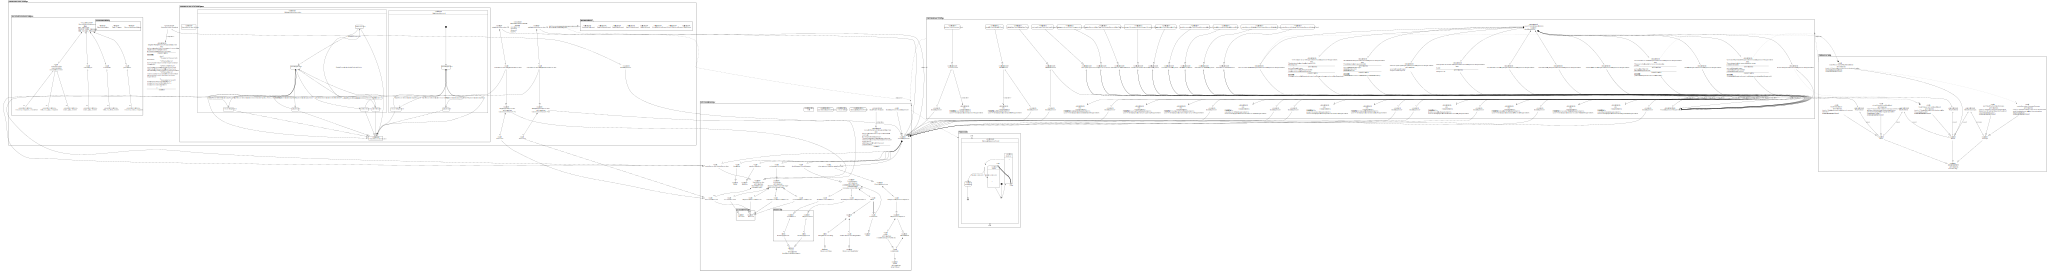

In [17]:
%viz PDBehavior PetFoodDispenser FDFriendlyVerfication FDispenserNGO FDVoiceRecoderAnalysis